# Simulating ethanol protein production in Saccharomyces cerevisiae with COBRApy

This notebook provides an introduction to constraint-based metabolic modelling with COBRApy, followed by several practical exercisesm where you will be expected to fill out the missing code.

We are going to work with a genome-scale metabolic model of yeast: [iMM904](http://bigg.ucsd.edu/models/iMM904).


**COBRApy** is a python package for constraint-based metabolic modelling. It contains functions for running various analyses, such as FBA, pFBA, FVA, flux sampling, building and editing models...
Here you can find the [COBRApy documentation](https://cobrapy.readthedocs.io/en/latest/).  
In case you prefer MATLAB, there is [COBRA Toolbox](https://opencobra.github.io/cobratoolbox/stable/). It has additional functionalities compared to COBRApy (e.g. omics integration).

COBRApy can read various model file types. We will use **SBML** (Systems Biology Markup Language) - one of the standard formats how to store a model. The advantage of this format is that it is both human an machine readable. This is what a reaction looks like:

<img src="../figures/sbml_rxn.png" alt="SBML reaction" style="width: 1000px;"/>


Metabolic models are often deposited in databases such as [BiGG Models](http://bigg.ucsd.edu/) or [BioModels](https://www.ebi.ac.uk/biomodels/).



In [1]:
# import necessary packages
import cobra  # cobrapy package
import escher  # package for visualization
import numpy as np  # many useful math & data analysis functions
import matplotlib.pyplot as plt  # plotting

In [2]:
# read the model
model = cobra.io.read_sbml_model("../models/iMM904.xml")

In [3]:
# basic overview of the model
model

Name,iMM904
Memory address,7fee4c9631d0
Number of metabolites,1226
Number of reactions,1577
Number of genes,905
Number of groups,0
Objective expression,1.0*BIOMASS_SC5_notrace - 1.0*BIOMASS_SC5_notrace_reverse_93090
Compartments,"cytosol, extracellular space, mitochondria, peroxisome/glyoxysome, endoplasmic reticulum, vacuole, golgi apparatus, nucleus"


In [4]:
# check what compartments the model has
model.compartments

{'c': 'cytosol',
 'e': 'extracellular space',
 'm': 'mitochondria',
 'x': 'peroxisome/glyoxysome',
 'r': 'endoplasmic reticulum',
 'v': 'vacuole',
 'g': 'golgi apparatus',
 'n': 'nucleus'}

## Metabolites

In [5]:
# access metabolites
model.metabolites[:5]

[<Metabolite 2dr5p_c at 0x7fee4c800910>,
 <Metabolite 2hb_c at 0x7fee4cf808d0>,
 <Metabolite 2hb_e at 0x7fee4c7171d0>,
 <Metabolite 2hhxdal_c at 0x7fee4c4fe010>,
 <Metabolite 2hp6mbq_m at 0x7fee4c4fe810>]

In [6]:
# access one metabolite with its ID and save it as a variable 
glucose = model.metabolites.get_by_id("glc__D_c") 
# model.metabolites.glc__D_c - shorter syntax, but does not work if metabolite ID starts with a number / contains brackets
glucose

Metabolite identifier,glc__D_c
Name,D-Glucose
Memory address,0x7fee4c4c09d0
Formula,C6H12O6
Compartment,c
In 11 reaction(s),"GLCtv, GALS3, GLUK, MALT, SBTR, DGGH, GLCGSD, HEX1, TREH, GLCt1, 13BGH"


In [7]:
# metabolite name - not unique (one metabolite can be present in several compartments)
glucose.name

'D-Glucose'

In [8]:
# formula
glucose.formula

'C6H12O6'

In [9]:
# database identifiers
glucose.annotation

{'sbo': 'SBO:0000247',
 'bigg.metabolite': 'glc__D',
 'biocyc': 'META:Glucopyranose',
 'chebi': ['CHEBI:12965', 'CHEBI:20999', 'CHEBI:4167', 'CHEBI:17634'],
 'hmdb': ['HMDB00122', 'HMDB06564'],
 'inchi_key': 'WQZGKKKJIJFFOK-GASJEMHNSA-N',
 'kegg.compound': 'C00031',
 'kegg.drug': 'D00009',
 'metanetx.chemical': 'MNXM41',
 'sabiork': ['1406', '1407'],
 'seed.compound': ['cpd26821', 'cpd00027']}

In [10]:
# list of participating reactions
glucose.reactions

frozenset({<Reaction 13BGH at 0x7fee4cf5cdd0>,
           <Reaction DGGH at 0x7fee4bdb5ed0>,
           <Reaction GALS3 at 0x7fee4b91cc50>,
           <Reaction GLCGSD at 0x7fee4b9bfad0>,
           <Reaction GLCt1 at 0x7fee4b9ec190>,
           <Reaction GLCtv at 0x7fee4b9ec210>,
           <Reaction GLUK at 0x7fee4bfe7a90>,
           <Reaction HEX1 at 0x7fee4b8a2b90>,
           <Reaction MALT at 0x7fee4b7f2fd0>,
           <Reaction SBTR at 0x7fee4b3c8490>,
           <Reaction TREH at 0x7fee4b28b550>})

## Reactions

In [11]:
model.reactions[:5]  

[<Reaction CITtcp at 0x7fee4c028090>,
 <Reaction 13BGH at 0x7fee4cf5cdd0>,
 <Reaction 13BGHe at 0x7fee4c028dd0>,
 <Reaction 13GS at 0x7fee4c6daa90>,
 <Reaction 16GS at 0x7fee4c7e3b10>]

In [12]:
# access one reaction
hexokinase = model.reactions.HEX1  # (or model.reactions.get_by_id("HEX1"))
hexokinase

Reaction identifier,HEX1
Name,Hexokinase (D-glucose:ATP)
Memory address,0x7fee4b8a2b90
Stoichiometry,atp_c + glc__D_c --> adp_c + g6p_c + h_c ATP C10H12N5O13P3 + D-Glucose --> ADP C10H12N5O10P2 + D-Glucose 6-phosphate + H+
GPR,YFR053C or YGL253W or YCL040W
Lower bound,0.0
Upper bound,999999.0


In [13]:
# participating metabolites - negative stoichiometric coefficient - reactants; positive - products
hexokinase.metabolites

{<Metabolite atp_c at 0x7fee4c420e50>: -1.0,
 <Metabolite glc__D_c at 0x7fee4c4c09d0>: -1.0,
 <Metabolite adp_c at 0x7fee4c591a50>: 1.0,
 <Metabolite g6p_c at 0x7fee4c492750>: 1.0,
 <Metabolite h_c at 0x7fee4c2fc690>: 1.0}

In [14]:
# upper bound (UB) of the reaction flux - maximum possible flux
# typically set to an arbitrary value like 999999 or 1000
# this represents an unlimited flux (we cannot set it to infinity, so we use arbitrarily high values)
hexokinase.upper_bound

999999.0

In [15]:
# lower bound (LB) of the reaction flux
# irreversible reactions have LB=0, reversible have LB=-999999 
hexokinase.lower_bound

0.0

## Important reactions
### Exchange reactions

Exchange reactions are arbitrary reactions (pseudoreactions) that let metabolites enter and leave the modeling system. Their lower and upper bounds can be changed according to experimentally measured uptake and secretion rates.

The exchange reactions have the form "M_e -> " or "M_e <-> ". There is a reactant but no product (or a product but not reactant). 

The model also contains the individual transporter reactions, e.g. "M_c -> M_e" - this represents a transporter that transports metabolite M from cytoplasm to extracellular space, and are often associated with genes.

So why do we need the exchange reactions?

* Steady state assumption. Metabolites cannot accumulate (**Sv=0**), so we need reactions that allow metabolites to enter and leave the system.

* There are often several transporters for the same metabolite and one transporter can often transport several types of molecules. But when we measure exchange rates in the lab, we don't know which transporter is doing the job, we just see the overall rate. Exchange reactions conveniently allow us to set the overall rate and we don't need to specify the rates for the individual transporters.

In [16]:
# list of exchange reactions. IDs typically start with "EX_"
model.exchanges[:5]

[<Reaction EX_epistest_SC_e at 0x7fee4c04db10>,
 <Reaction EX_epist_e at 0x7fee4c059110>,
 <Reaction EX_ergst_e at 0x7fee4bcf6750>,
 <Reaction EX_ergstest_SC_e at 0x7fee4bcefdd0>,
 <Reaction EX_13BDglcn_e at 0x7fee4bcf7110>]

**Glucose uptake rate**  
Notice how the reaction is defined. If it is going forward, glucose leaves the system - it is secreted. Reverse direction indicates uptake.
In this model, glucose has a default LB = -10. This means the maximum uptake rate is 10 mmol/(gDW*h)

In [17]:
model.reactions.EX_glc__D_e 

Reaction identifier,EX_glc__D_e
Name,D-Glucose exchange
Memory address,0x7fee4bb1ed50
Stoichiometry,glc__D_e <=> D-Glucose <=>
GPR,
Lower bound,-10.0
Upper bound,999999.0


### Growth medium - summarizes what uptakes are allowed in the model
Growth medium typically contains one or more carbon sources, nitrogen source, water and various ions. 

The values are **lower bounds** of the uptake rates [mmol/gDW h]. Some metabolites have a default value (e.g. glucose and O2)  based on measurements. Others have an unlimited uptake (value of 999999), meaning that the cells can take up as much as they want.
Note that they are shown as abs. values (if you look at the LB and UB of exchange reactions, uptake rates have negative value, secretion rates positive).

In [18]:
model.medium

{'EX_fe2_e': 999999.0,
 'EX_glc__D_e': 10.0,
 'EX_h2o_e': 999999.0,
 'EX_h_e': 999999.0,
 'EX_k_e': 999999.0,
 'EX_na1_e': 999999.0,
 'EX_so4_e': 999999.0,
 'EX_nh4_e': 999999.0,
 'EX_o2_e': 2.0,
 'EX_pi_e': 999999.0}

### Biomass reaction

An artificial reaction that represents a drain of metabolites towards growth. It represents the cellular composition - the amount of amino acids in proteins, DNA, RNA, lipids, carbohydrates, ATP...

In [19]:
model.reactions.BIOMASS_SC5_notrace

Reaction identifier,BIOMASS_SC5_notrace
Name,Biomass SC5 notrace
Memory address,0x7fee4b105110
Stoichiometry,1.1348 13BDglcn_c + 0.4588 ala__L_c + 0.046 amp_c + 0.1607 arg__L_c + 0.1017 asn__L_c + 0.2975 asp__L_c + 59.276 atp_c + 0.0447 cmp_c + 0.0066 cys__L_c + 0.0036 damp_c + 0.0024 dcmp_c + 0.0024... 1.1348 1 3 beta D Glucan C6H10O5 + 0.4588 L-Alanine + 0.046 AMP C10H12N5O7P + 0.1607 L-Arginine + 0.1017 L-Asparagine + 0.2975 L-Aspartate + 59.276 ATP C10H12N5O13P3 + 0.0447 CMP C9H12N3O8P +...
GPR,
Lower bound,0.0
Upper bound,999999.0


### ATP maintenance reaction
Another artificial reaction which represents non-growth associated maintenance energy. This is energy that cells need just to survive (even if they do not grow). It represents energy use by processes like maintenance of chemical gradients or macromolecule turnover. It was shown that [it improves flux predictions if it is included as a model parameter.](https://doi.org/10.1371/journal.pcbi.1009022)

In [20]:
model.reactions.ATPM 

Reaction identifier,ATPM
Name,ATP maintenance requirement
Memory address,0x7fee4bee2150
Stoichiometry,atp_c + h2o_c --> adp_c + h_c + pi_c ATP C10H12N5O13P3 + H2O H2O --> ADP C10H12N5O10P2 + H+ + Phosphate
GPR,
Lower bound,1.0
Upper bound,1.0


## Genes
Typically models have **gene protein reaction (GPR) rules** - associations of reactions with genes.
One reaction is often associated with several genes and the relationship is expressed with **AND** / **OR** rules.
* **AND** rule - e.g. **Gene1 AND Gene2** - both genes are needed to catalyze reaction (e.g. two subunits)
* **OR** rule - **Gene1 OR Gene2** - isoenzymes

Also combinations are possible, e.g. **(Gene1 AND Gene2) OR (Gene1 AND Gene3)**.   

One gene often participates in several reactions - e.g. promiscuous enzymes.

In [21]:
# access model genes
model.genes[:5]

[<Gene YHR104W at 0x7fee4c59cdd0>,
 <Gene YDR368W at 0x7fee4c6b7c10>,
 <Gene YGR282C at 0x7fee4c799510>,
 <Gene YOL086C at 0x7fee4c2db550>,
 <Gene YLR300W at 0x7fee4c2db7d0>]

In [22]:
# examine GPR rule for hexokinase
hexokinase.gene_reaction_rule

'YFR053C or YGL253W or YCL040W'

In [23]:
# for a given gene, find all reactions where it occurs
model.genes.get_by_id("YHR104W").reactions

frozenset({<Reaction ALCD19y at 0x7fee4befb690>,
           <Reaction ARABR at 0x7fee4be0ac50>,
           <Reaction LALDO3 at 0x7fee4b76b350>,
           <Reaction SBTR at 0x7fee4b3c8490>,
           <Reaction XYLR at 0x7fee4b2d20d0>})

## Looking up stuff
If you don't know the name of your metabolite/reaction/gene, you can search for certain words in the model.  
Note: the search is case sensitive.

In [24]:
# you can search for the metabolite name
model.metabolites.query("Glucose", "name")

[<Metabolite 6dg_c at 0x7fee4c568a50>,
 <Metabolite g1p_c at 0x7fee4c48a390>,
 <Metabolite g6p_c at 0x7fee4c492750>,
 <Metabolite g6p_r at 0x7fee4c4941d0>,
 <Metabolite glc__D_c at 0x7fee4c4c09d0>,
 <Metabolite glc__D_e at 0x7fee4c4c1a10>,
 <Metabolite glc__D_v at 0x7fee4c4c3d10>]

In [25]:
# reaction name
model.reactions.query("Hexokinase", "name")

[<Reaction HEX1 at 0x7fee4b8a2b90>,
 <Reaction HEX4 at 0x7fee4ba0ad50>,
 <Reaction HEX7 at 0x7fee4b8aa990>]

## Changing constraints
Often we measure uptake and secretion rates of metabolites when performing cell cultivations. E.g. we might measure glucose uptake and ethanol secretion rate. We integrate these into the model by changing the **lower and upper bounds of the exchange reactions**.

Typically, the units of the exchange reactions are mmol/(gDW h).
Negative values - uptake, positive - secretion.

In [26]:
# changing constraints
glc_uptake = model.reactions.get_by_id("EX_glc__D_e")
glc_uptake

Reaction identifier,EX_glc__D_e
Name,D-Glucose exchange
Memory address,0x7fee4bb1ed50
Stoichiometry,glc__D_e <=> D-Glucose <=>
GPR,
Lower bound,-10.0
Upper bound,999999.0


In [27]:
# disable glucose uptake
glc_uptake.lower_bound = 0  # or directly model.reactions.EX_glc__D_e.lower_bound = 0
glc_uptake

Reaction identifier,EX_glc__D_e
Name,D-Glucose exchange
Memory address,0x7fee4bb1ed50
Stoichiometry,glc__D_e --> D-Glucose -->
GPR,
Lower bound,0
Upper bound,999999.0


In [28]:
# set it back to original value
glc_uptake.lower_bound = -10

Often you will test various conditions (e.g. various carbon sources, various levels of substrates etc...).
You always need to make sure to reset the values back to the original value.
A very helpful function for this is **with statement**. *What happens in with statement stays in with statement.*

In [29]:
with model:
    # everything that happens here in the indented block is reset afterwards
    glc_uptake.lower_bound = -5
    print(f"Uptake rate inside 'with' statement: {glc_uptake.lower_bound}")
    
print(f"Uptake rate outside 'with' statement: {glc_uptake.lower_bound}")

Uptake rate inside 'with' statement: -5
Uptake rate outside 'with' statement: -10


**Note**  
Normally in jupyter notebooks, if something is on the last line, it will be automatically printed (e.g. if you just type ```glc_uptake.lower_bound```). If you want to print something inside of a "with statement" or a "for loop", you need to put it inside of a ```print()``` function. 

## Performing simulations

Before running FBA we have to choose an **objective function**, that we want to maximize or minimize. Typically this is maximiation of biomass production. Another option would be maximization of secretion of a certain product (e.g. ethanol).

In [30]:
model.objective = "BIOMASS_SC5_notrace"

In [31]:
# Perform FBA
fba = model.optimize("maximize")
fba
# Reduced costs - impact of an increase of the flux through the respective reaction on the final objective value

,fluxes,reduced_costs
CITtcp,0.000000e+00,-0.000000e+00
13BGH,0.000000e+00,-4.751566e-02
13BGHe,0.000000e+00,-6.938894e-18
13GS,3.266700e-01,-6.938894e-18
16GS,0.000000e+00,-9.503132e-02
...,...,...
PYDXO,0.000000e+00,6.075178e-18
PYK,1.772199e+01,-5.551115e-17
PYNP2r,4.707470e-19,2.557013e-17
PYR5CDm,1.947497e-17,-2.602085e-18


In [32]:
# access the objective value (growth rate in 1/h)
fba.objective_value

0.2878657037040186

In [33]:
# access fluxes (in mmol/(gDW*h))
fba.fluxes

CITtcp     0.000000e+00
13BGH      0.000000e+00
13BGHe     0.000000e+00
13GS       3.266700e-01
16GS       0.000000e+00
               ...     
PYDXO      0.000000e+00
PYK        1.772199e+01
PYNP2r     4.707470e-19
PYR5CDm    1.947497e-17
PYRDC      1.594605e+01
Name: fluxes, Length: 1577, dtype: float64

In [34]:
# get a nice summary with you objective and uptake/secretion rates
model.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
glc__D_e,EX_glc__D_e,10,6,100.00%
nh4_e,EX_nh4_e,1.611,0,0.00%
o2_e,EX_o2_e,2,0,0.00%
pi_e,EX_pi_e,0.05691,0,0.00%
so4_e,EX_so4_e,0.02225,0,0.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
co2_e,EX_co2_e,-18.02,1,36.29%
etoh_e,EX_etoh_e,-15.82,2,63.70%
for_e,EX_for_e,-0.001488,1,0.00%
h2o_e,EX_h2o_e,-5.64,0,0.00%


In [35]:
# this command also runs FBA, but the only output is the objective value
# advantage - faster (can be useful if you need to run thousands of simulations)
model.slim_optimize()

0.28786570370400216

### Parsimonious FBA
* it first maximizes your objective
* then it minimizes the sum of fluxes
* often better solutions for fluxes (not so many extreme values, cycles) - recommended


In [36]:
pfba = cobra.flux_analysis.pfba(model)
pfba.objective_value  # this is not the growth rate but the sum of fluxes

338.00599158210844

In [37]:
# to access growth rate, we have to look at the flux of the primary objective
pfba.fluxes.BIOMASS_SC5_notrace

0.2878657037040181

## Knock-outs
Why simulate knock-outs?
* Determine whether a reaction is essential for growth/other functions
* Improve properties of a cell (e.g. remove reactions that secrete waste products)
* Test different genotypes (e.g. drug sensitivity of cancer cells with different mutations) 

We can either knock out reactions or genes.

In [38]:
# Reaction knock-out
with model:
    model.reactions.CYOR_u6m .knock_out()
    print(f"Growth rate after KO: {model.slim_optimize()}") 

# outside "with" statement, the model is back to normal
print(f"Wild type growth rate {model.slim_optimize()}")

Growth rate after KO: 0.20932926167108334
Wild type growth rate 0.2878657037040181


In [39]:
# Gene knock-out
with model:
    model.genes.get_by_id("YBL045C").knock_out()
    print(f"Growth rate after KO: {model.slim_optimize()}") 

# outside "with" statement, the model is back to normal
print(f"Wild type growth rate {model.slim_optimize()}")

Growth rate after KO: 0.20932926167109087
Wild type growth rate 0.28786570370401654


# Exercises
First we will define our growth medium. The default medium is minimal - it contains one carbon source (glucose), one nitrogen source (ammonium), H2O and ions.

For anaerobic growth we also need lipids in the medium.

In [40]:
# it is unlikely that the uptake of lipids would be higher than glucose
model.reactions.EX_ergstest_SC_e.lower_bound = -10
model.reactions.EX_zymstest_SC_e.lower_bound = -10
model.reactions.EX_ptd1ino_SC_e.lower_bound = -10

# check what is in the medium
model.medium

{'EX_ergstest_SC_e': 10,
 'EX_fe2_e': 999999.0,
 'EX_glc__D_e': 10,
 'EX_h2o_e': 999999.0,
 'EX_h_e': 999999.0,
 'EX_k_e': 999999.0,
 'EX_na1_e': 999999.0,
 'EX_so4_e': 999999.0,
 'EX_nh4_e': 999999.0,
 'EX_o2_e': 2.0,
 'EX_pi_e': 999999.0,
 'EX_ptd1ino_SC_e': 10,
 'EX_zymstest_SC_e': 10}

## Exercise 1 - FBA in various conditions
### Aerobic growth on glucose

In [41]:
with model:
    # set glucose uptake rate and perform FBA
    model.reactions.EX_glc__D_e.lower_bound = -10
    fba1 = cobra.flux_analysis.pfba(model)
    mu1 = fba1.fluxes.BIOMASS_SC5_notrace
    
    # print results
    print(f"Growth rate in aerobic conditions: {mu1}")

Growth rate in aerobic conditions: 0.2930205159160646


#### Visualisation

In [42]:
# available maps for different models
escher.list_available_maps()

[{'organism': 'Saccharomyces cerevisiae',
  'map_name': 'iMM904.Central carbon metabolism'},
 {'organism': 'Homo sapiens',
  'map_name': 'RECON1.Inositol retinol metabolism'},
 {'organism': 'Homo sapiens', 'map_name': 'RECON1.Glycolysis TCA PPP'},
 {'organism': 'Homo sapiens', 'map_name': 'RECON1.Tryptophan metabolism'},
 {'organism': 'Homo sapiens', 'map_name': 'RECON1.Carbohydrate metabolism'},
 {'organism': 'Homo sapiens',
  'map_name': 'RECON1.Amino acid metabolism (partial)'},
 {'organism': 'Escherichia coli', 'map_name': 'iJO1366.Nucleotide metabolism'},
 {'organism': 'Escherichia coli',
  'map_name': 'iJO1366.Fatty acid biosynthesis (saturated)'},
 {'organism': 'Escherichia coli',
  'map_name': 'iJO1366.Nucleotide and histidine biosynthesis'},
 {'organism': 'Escherichia coli', 'map_name': 'e_coli_core.Core metabolism'},
 {'organism': 'Escherichia coli', 'map_name': 'iJO1366.Central metabolism'},
 {'organism': 'Escherichia coli',
  'map_name': 'iJO1366.Fatty acid beta-oxidation'}

In [43]:
# these commands will create html files which you can open in a browser
builder = escher.Builder('iMM904.Central carbon metabolism',
                       reaction_data=fba1.fluxes)
builder.save_html(f"../results/FBA_aerobic.html")

### Perform the same analysis for 1. anaerobic + glucose, 2. aerobic condition + acetate


In [44]:
model.reactions.query("O2 exchange", "name")

[<Reaction EX_co2_e at 0x7fee4bb51b10>, <Reaction EX_o2_e at 0x7fee4bb8e950>]

In [45]:
model.reactions.query("Acetate exchange", "name")

[<Reaction EX_ac_e at 0x7fee4bb1c9d0>]

In [46]:
with model:
    # set oxygen uptake to zero
    model.reactions.EX_o2_e.lower_bound = 0

    # set glucose uptake rate and perform FBA
    model.reactions.EX_glc__D_e.lower_bound = -10
    fba2 = cobra.flux_analysis.pfba(model)
    mu2 = fba2.fluxes.BIOMASS_SC5_notrace

    # print results
    print(f"Anaerobic growth rate with glucose as carbon source: {mu2}")

Anaerobic growth rate with glucose as carbon source: 0.21113285779546503


In [47]:
with model:
    # set oxygen uptake to zero
    model.reactions.EX_ac_e.lower_bound = -10

    # set glucose uptake rate and perform FBA
    model.reactions.EX_glc__D_e.lower_bound = 0
    fba3 = cobra.flux_analysis.pfba(model)
    mu3 = fba3.fluxes.BIOMASS_SC5_notrace

    # print results
    print(f"Anaerobic growth rate with glucose as carbon source: {mu3}")

Anaerobic growth rate with glucose as carbon source: 0.025894538149225925


## Exercise 2 - ethanol production envelope in anaerobic conditions
You are interested in ethanol production capabilities of your strain. To analyse ethanol production at different growth rates, make a production envelope: 
* make a list of growth rates from zero to maximum possible
* go over the list of growth rates step by step and use them as a constraint (lower bound)
* set ethanol as the objective and minimize & maximize its secretion
* plot your results (x-axis - growth rate, y-axis - min. and max. ethanol secretion)

In [48]:
model.reactions.query("Ethanol exchange", "name")

[<Reaction EX_etoh_e at 0x7fee4bb04610>]

The plot above shows all possible growth rate and ethanol secretion values. Up to growth rate of around 0.23, ethanol secretion can be anywhere between 0 and the maximum value. Above this growth rate, ethanol always has to be produced - this phenomenon is called **growth coupling**. In this case, it is a **weak coupling**, because there are growth rates where ethanol production can be theoretically zero.

In [49]:
# make empty lists that will be used to store the maximum and minimum values of ethanol production
max_etoh_ana = []
min_etoh_ana = []

# make a list of tested growth rates
mus_ana = np.linspace(0, mu2, 10)

# loop over the list of growth rates
for mu in mus_ana:
    with model:
        # set glucose uptake, biomass and turn off O2 uptake
        model.reactions.EX_o2_e.lower_bound = 0
        model.reactions.EX_glc__D_e.lower_bound = -10
        model.reactions.BIOMASS_SC5_notrace.lower_bound = mu

        # set objective to ethanol exchange
        model.objective = "EX_etoh_e"

        # maximize and minimize production
        max_etoh_ana.append(model.optimize("maximize").objective_value)
        min_etoh_ana.append(model.optimize("minimize").objective_value)


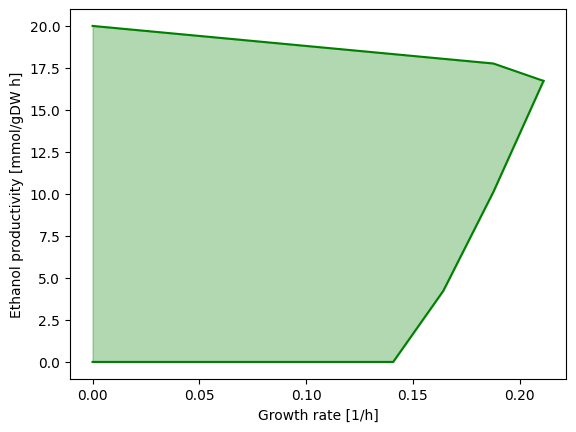

In [50]:
# plot solution space - these are (theoretically) all possible growth rates and ethanol secretion rates that cell can achieve
plt.plot(mus_ana, max_etoh_ana, color = "green")
plt.plot(mus_ana, min_etoh_ana, color = "green")
plt.xlabel("Growth rate [1/h]")
plt.ylabel("Ethanol productivity [mmol/gDW h]")
plt.fill_between(mus_ana, min_etoh_ana, max_etoh_ana, color = "green", alpha = 0.3)

We observe stronger growth coupling - above the growth rate of around 0.14, cells have to produce ethanol.

## Exercise 3 - ethanol production envelope after KOs in anaerobic conditions
A common way how to achieve growth coupling is by making certain knock-out(s). These ensure that the cell has to produce the product of interest (basically because all other alternative pathways are gone). There are algorithms which can predict these, such as **OptKnock, RobustKnock, OptCouple**... However, they are computationally demanding (take a long time to run, especially if you are looking for double, triple, quadruple... KOs, because they have to test all possible combinations of KOs).

Here we are going to try effects of KOs that were previously idendified in [von Kamp, A., & Klamt, S. (2017)](https://dx.doi.org/10.1038%2Fncomms15956): Glycerol 3 phosphate dehydrogenase (NAD), Malate dehydrogenase and NADH dehydrogenase.

In [51]:
# reactions to be knocked out
KOs = ["G3PD1ir", "MDH", "NADH2_u6cm"]

In [52]:
# make empty lists that will be used to store the maximum and minimum values of ethanol production
max_etoh_KOs = []
min_etoh_KOs = []

# determine maximum growth rate after making the knock outs
with model:
    for KO in KOs:
        model.reactions.EX_o2_e.lower_bound = 0
        model.reactions.EX_glc__D_e.lower_bound = -10
        model.reactions.get_by_id(KO).knock_out()
    mu_max_KO = model.slim_optimize()

# make a list of tested growth rates
mus_KOs = np.linspace(0, mu_max_KO, 10)

# loop over the list of growth rates
for mu in mus_KOs:
    with model:
        # perform knock_outs
        for KO in KOs:
            model.reactions.get_by_id(KO).knock_out()

        # set glucose uptake, biomass and turn off O2 uptake
        model.reactions.EX_glc__D_e.lower_bound = -10
        model.reactions.BIOMASS_SC5_notrace.lower_bound = mu
        model.reactions.EX_o2_e.lower_bound = 0

        # set objective to ethanol exchange
        model.objective = "EX_etoh_e"

        # maximize and minimize production
        max_etoh_KOs.append(model.optimize("maximize").objective_value)
        min_etoh_KOs.append(model.optimize("minimize").objective_value)


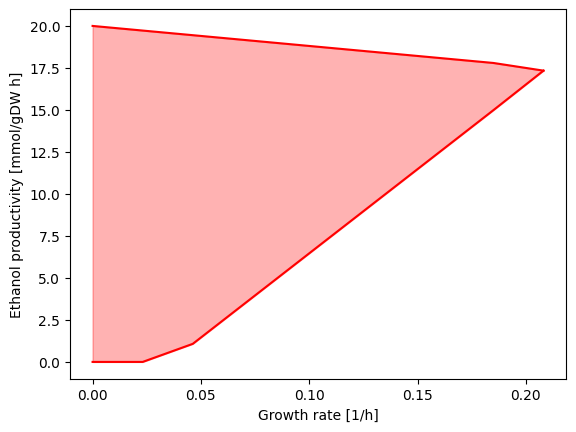

In [53]:
# plot solution space - these are (theoretically) all possible growth rates and ethanol secretion rates that cell can achieve
plt.plot(mus_KOs, max_etoh_KOs, color = "red")
plt.plot(mus_KOs, min_etoh_KOs, color = "red")
plt.xlabel("Growth rate [1/h]")
plt.ylabel("Ethanol productivity [mmol/gDW h]")
plt.fill_between(mus_KOs, min_etoh_KOs, max_etoh_KOs, color = "red", alpha = 0.3)

We see that after making the konck-outs we observe much stronger growth coupling. When the cells grow above 0.01, they have to produce ethanol. 

Can you think of an explanation why we observe growth coupling after making these knock-outs?